# Bayesian Optimization of a Laser

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from fdtd import fdtd1d_laser
except:
    !pip install git+https://github.com/natsunoyuki/FDTD
    from fdtd import fdtd1d_laser

try:
    from bayes_opt import BayesianOptimization, UtilityFunction
except:
    !pip install bayesian_optimization
    from bayes_opt import BayesianOptimization, UtilityFunction

try:
    from skopt import Optimizer 
except:
    !pip install scikit_optimize
    from skopt import Optimizer 

# bayes_opt

In [3]:
def run_and_measure_laser(D0, n_iter = 50000, t_measure = 10000): 
    # Run 1D FDTD laser simulation for pump strength D0.
    fdtd = fdtd1d_laser(D0 = D0)
    fdtd.run(initiate_pulse = True, n_iter = n_iter) 
    # Measure the output lasing power.
    E = np.abs(fdtd.E_measure)[-t_measure:]
    t = np.arange(0, len(E) * fdtd.dt, fdtd.dt)
    P = np.trapz(E, t)
    return P

In [4]:
def optimize_laser(target_power, n_iter = 15):  
    # Initialize the optimizer.
    pbounds = {"D0": [1, 20]} # Search bounds.
    optimizer = BayesianOptimization(f = None, pbounds = pbounds, 
                                     random_state = 42)
    # Upper confidence bounds utility function.
    utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)
    
    D0s = np.array([np.nan] * n_iter)
    lasing_powers = D0s.copy()
    targets = D0s.copy() 

    # Iterate the optimizer for n_iter iterations.
    for i in range(n_iter):
        # Optimizer suggests a value of D0 to try.
        next_point = optimizer.suggest(utility)
 
        # Perform the lasing measurements.
        lasing_power = run_and_measure_laser(**next_point) 
        # Minimize the difference between lasing_power and 
        # target_power.
        target = -np.abs(lasing_power - target_power) 
        # Store the results for output.
        D0s[i] = next_point["D0"]
        lasing_powers[i] = lasing_power
        targets[i] = target 

        try:
            # Update the optimizer with the evaluation results. 
            # This needs to be in try-except structure in order
            # to prevent repeat errors from occuring.
            optimizer.register(params = next_point, target = target)
        except:
            pass
        
    return optimizer, D0s, lasing_powers, targets

100%|██████████| 50000/50000 [00:04<00:00, 11384.82it/s]


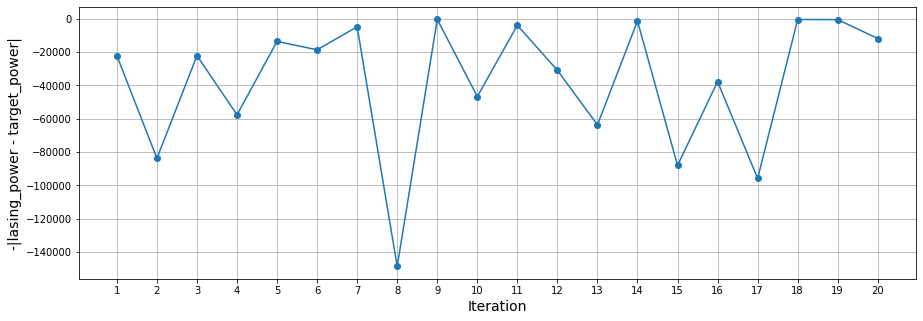

In [5]:
target_power = 215233
n_iter = 20
optimization_results = optimize_laser(target_power, n_iter)
optimizer = optimization_results[0]
D0s = optimization_results[1]
lasing_powers = optimization_results[2]
targets = optimization_results[3]

# Get the best results.
D0 = optimizer.max["params"]["D0"]
target = optimizer.max["target"]
lasing_power = int(lasing_powers[np.where(D0s == D0)[0]][0])

# Plot the optimization iterations.
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1+len(optimizer.space.target)), 
         optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("-|lasing_power - target_power|", fontsize = 14)
plt.xticks(range(1, 1+len(optimizer.space.target)))
plt.show()

In [6]:
print("Optimized pump strength value: {:.3f}.".format(D0))
print("Output power: {}.".format(lasing_power))

Optimized pump strength value: 9.943.
Output power: 214871.


# skopt

In [13]:
def optimize_laser_2(target_power, n_iter = 15):  
    # Initialize the optimizer.
    optimizer = Optimizer(dimensions = [(1, 20)], n_initial_points = 10, acq_func = "LCB")
    D0s = []
    lasing_powers = []
    targets = []

    for i in range(n_iter):
        next_point = optimizer.ask()
        lasing_power = run_and_measure_laser(*next_point) 
        target = np.abs(lasing_power - target_power) 

        D0s.append(next_point[0])
        lasing_powers.append(lasing_power)
        targets.append(target )

        optimizer.tell(next_point, target)
        
    return optimizer, D0s, lasing_powers, targets

In [14]:
optimizer, D0s, lasing_powers, targets = optimize_laser_2(215233, 20)

100%|██████████| 50000/50000 [00:03<00:00, 13375.87it/s]
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
100%|██████████| 50000/50000 [00:03<00:00, 13287.91it/s]
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
100%|██████████| 50000/50000 [00:03<00:00, 13093.57it/s]
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
100%|██████████| 50000/50000 [00:05<00:00, 9967.18it/s]
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
1

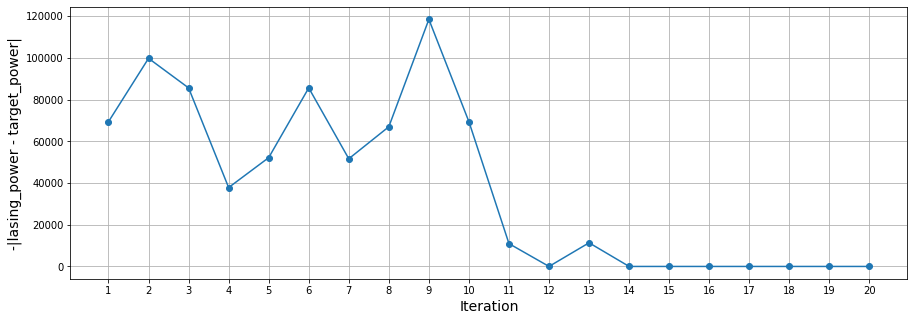

In [16]:
# Plot the optimization iterations.
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1+len(targets)), targets, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("-|lasing_power - target_power|", fontsize = 14)
plt.xticks(range(1, 1+len(targets)))
plt.show()